In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import bisect
from scipy import spatial

import inv_cdfs as icdf
import agents_network as anet
import utils

In [2]:
def two_moons(num_peers,moon_radius,moon_var):
    X=np.zeros((num_peers,2))
    for i in range(int(num_peers/2)):
        r = moon_radius + 4*i/num_peers
        t = i*3/num_peers*np.pi
        X[i, 0] = r*np.cos(t)
        X[i, 1] = r*np.sin(t)
        X[i + int(num_peers/2), 0] = r*np.cos(t + np.pi)
        X[i + int(num_peers/2), 1] = r*np.sin(t + np.pi)
    X= X + np.sqrt(moon_var) * np.random.normal(size=(num_peers, 2))
    Y = np.ones(num_peers)
    Y[:int(num_peers/2)]=2
    return [X,Y.astype(int)]

We start by creating $n$ agents which are in $\mathbb{R}^p$. These agents are split in two groups, some of them are labelled $y=1$ and others $y=2$.

In [3]:
npeers, p = 100, 2 # number of agents, dimension
nsamples = np.random.randint(5,15,size=npeers)

'''
# First configuration : 
n1 = int(npeers/2)
n2 = npeers-n1
t, R = 2*np.pi*np.random.randn(n1,1), 3
r = R*(1.5 + .2*np.random.randn(n1,1)) # radius
X1 = np.hstack((np.cos(t)*r, np.sin(t)*r));
X = np.vstack((X1, np.random.randn(n2,2)))
y = np.vstack(( np.ones([n1,1]), 2*np.ones([n2,1]) ))
'''

# Second configuration :
X, y = two_moons(num_peers=npeers, moon_radius = 1, moon_var=0.01)
n1, n2 = npeers/2, npeers/2

We plot the agents. Those in blue are labelled $y=1$ and in orange are labelled $y=2$.

(-2.682952834837269,
 2.701699835329635,
 -3.1804660371353326,
 3.4385051859860214)

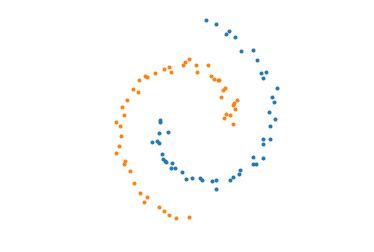

In [4]:
I = np.nonzero(y==1)[0]
J = np.nonzero(y==2)[0]
plt.plot(X[I,0], X[I,1], '.')
plt.plot(X[J,0], X[J,1], '.')
plt.axis('equal')
plt.axis('off')

The following function generate specific datas for each agent. Depending on their labelled and $\|x\|_2$, each agent received data from different distributions.

In [5]:
def create_data(x, y ,nsamples=1000):
    if y==1:
        #data = np.random.poisson(np.linalg.norm(x), nsamples)
        data = ss.norm.rvs(0, size=nsamples) # gaussians
        #data = np.random.poisson(5, nsamples)
    elif y==2:
        data = ss.norm.rvs(10, size=nsamples) # gaussians
        # data = ss.expon.rvs(np.linalg.norm(x), size=nsamples)
    else:
        print("choose y in {1,2}")
    return data

We define DATA to be list of data received by each agent. Then, we plot two examples :

In [6]:
DATA = [create_data(X[k], y[k], nsamples=nsamples[k]) for k in range(npeers)]

i, j = np.random.choice(I), np.random.choice(J)
print('i=', i, 'et j=', j)
print('data for an element of I : ', DATA[i][:10])
print('data for an element of J : ', DATA[j][:10])

i= 99 et j= 11
data for an element of I :  [-0.76316335 -0.17747446 -0.72567671  1.19765725  0.06633187  0.35402742]
data for an element of J :  [10.37994515  7.70175229 10.3995716   8.32452182  9.0969544   9.63037517
  7.61541577 10.39839973]


We build the similarity matrix.

In [7]:
def distmat(X, Z):
    return spatial.distance.cdist(X,Z)**2

M = np.zeros((npeers,npeers))
for k in range(npeers):
    M[k,:] = (y[k]==y).flatten()
def Similarities_Trucquée(X,sigma):
    a = np.tensordot(np.linalg.norm(X,axis=1),np.ones(npeers),0)
    b = np.tensordot(np.ones(npeers),np.linalg.norm(X,axis=1),0)
    similarities = np.exp( -abs(a-b)/(2*sigma**2) )
    np.fill_diagonal(similarities, 0)
    return similarities*M

def Similarities_knn(X,k,sigma):    
    similarities = np.exp( -distmat(X,X)/(2*sigma**2) )
    np.fill_diagonal(similarities, 0)
    ind = np.argsort(-similarities, axis=1)
    ind =  ind[:,0:k].flatten()
    index = np.zeros_like(similarities)
    for i,x in enumerate(ind):
        index[i//k,x] = 1
    similarities = similarities*(index+index.T>0)
    return similarities
    

We look the similarity matrix thanks to the functions defines above.

[0.99014402 0.95722167 0.97264569 0.95722167 0.99728257 0.99728257
 0.99468468 0.99540393 0.99014402 0.97814751]


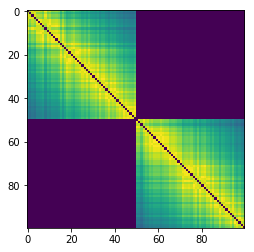

In [8]:
sigma = 1
W = Similarities_Trucquée(X,sigma)
k = 5
#W = Similarities_knn(X,k,sigma)
plt.imshow(W)
print(np.max(W, axis=1)[:10])

Now, we define two methods to calculate density functions from datas :

In [9]:
def methode_Noyau(data, K=ss.norm.pdf):
    nsamples = len(data)
    sigma = data.std()
    h = sigma/nsamples**(0.2) # thumb rule
    densite = lambda y : np.sum([K((y-x)/h) for x in data])/(nsamples*h)
    return densite

def methode_MC(data):
    ensemble_des_valeurs, Nb_occurences = np.unique(data, return_counts=True)
    prob =  Nb_occurences/np.sum(Nb_occurences)
    return ensemble_des_valeurs, prob

We plot the density got from an agent labelled $y=1$.

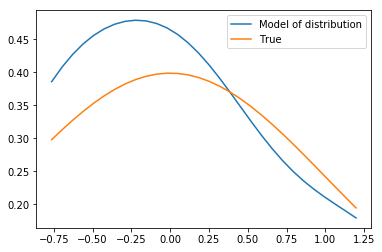

In [10]:
data = DATA[i]
densite = methode_Noyau(data)
tt = np.linspace(np.min(data), np.max(data), 30)
plt.plot(tt, [densite(t) for t in tt], label='Model of distribution')
#plt.plot(tt, ss.expon.pdf(tt,np.linalg.norm(X[j])), label='True')
plt.plot(tt, ss.norm.pdf(tt,0), label='True')
plt.legend()

We plot the density got from an agent labelled $y=2$.

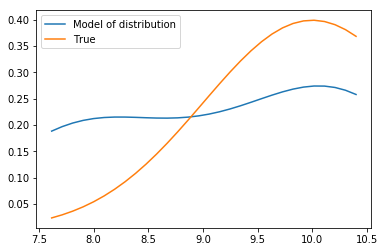

In [11]:
data = DATA[j]
densite = methode_Noyau(data)
tt = np.linspace(np.min(data), np.max(data), 30)
plt.plot(tt, [densite(t) for t in tt], label='Model of distribution')
#plt.plot(tt, ss.expon.pdf(tt,np.linalg.norm(X[j])), label='True')
plt.plot(tt, ss.norm.pdf(tt,10), label='True')
plt.legend()

Once we have the densities, we need the functions $g_s(v)$. Firstly, we define the cumulative empirical function $F$, and then $g$ represents its inverse. 

In [12]:
def F(data):
    nsamples = len(data)
    data_sorted = np.sort(data)
    return lambda t : bisect.bisect(data_sorted,t)/nsamples

def g(data):
    nsamples = len(data)
    ensemble_des_valeurs, Nb_occurences = np.unique(data, return_counts=True)
    prob_cum = np.cumsum(Nb_occurences)/nsamples
    return prob_cum, ensemble_des_valeurs

For $u,v$ two neighbors, we plot $g_s(u)$ and $g_s(v)$ :

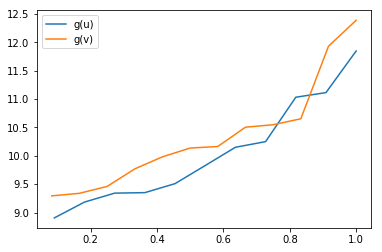

In [13]:
G = [g(data) for data in DATA]
u = np.random.randint(npeers)
v = np.argmax(W[u])

xx, yy = G[u]
plt.plot(xx, yy, label='g(u)')
xx, yy = G[v]
plt.plot(xx, yy, label='g(v)')
plt.legend()

We find that neighbor agents have very similar distributions. In conclusion, they can exchange information to better learn their models. Now, we give a method to get the probability density function from $g_s(v)$.

In [14]:
invcdfs = [icdf.InvCdf(np.linspace(0, 1, nsamples[k]), np.interp(xx, G[k][0], G[k][1])) for k in range(npeers)]

# Stack agents in a list
agents = [anet.Agent(npeers, k, invcdfs[k]) for k in range(npeers)]

# Confidence in every model
C = 1/nsamples #np.ones(npeers)

# Build network
network = anet.AgentNetwork(W, C, agents, mu=25)

# Run asynchronous gossip algorithm
network.iterate_async_gossip(100)
# Update finale model for each agents
network.update_invcdf_models()
# Une fois que cela est fait, pour chaque agent la seule chose qui nous interesse 
# Est l'attribut "invcdf_model" qui contient un objet InvCdf qui contient la fonction de répartition inverse
# de la distribution apprise par l'agent
# On les stocke dans une list
invcdfs = [network.agents[k].invcdf_model for k in range(0, npeers)]
# Fill the cdf from those models for each agent
for invcdf in invcdfs:
    invcdf.fill_cdf(start=-3, stop=13, nsamples_cdf=10000)

No handles with labels found to put in legend.


Text(0.5,1,'Après propagation')

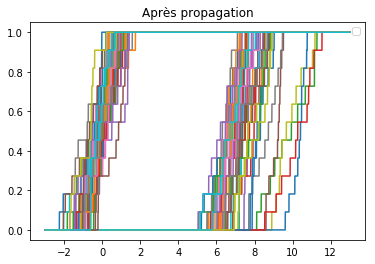

In [15]:
invcdfs = [network.agents[i].invcdf_model for i in range(0, npeers)]# Plot propagated cdfs
plt.figure()
for k in range(0, npeers):
    plt.plot(invcdfs[k].ts, invcdfs[k].cdf)#, label=i)
plt.legend()
plt.title("Après propagation")

Maintenant on affiche les cdf calculées avant propagation aux mêmes points ts.

No handles with labels found to put in legend.


Text(0.5,1,'Avant propagation')

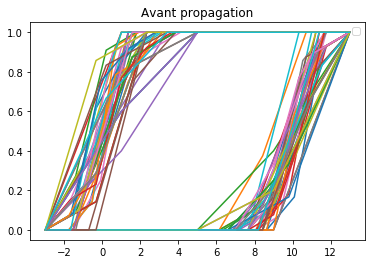

In [16]:
plt.figure()
for k in range(npeers):
    f = F(DATA[k])
    ts = np.linspace(-3,13,nsamples[k])
    plt.plot(ts, np.array([f(t) for t in ts]))
plt.legend()
plt.title("Avant propagation")

On affiche les cdf calculées avant propagation à des points spécifiques pour chaque agent (les résultats doivent être légèrement meilleurs).

No handles with labels found to put in legend.


Text(0.5,1,'Avant propagation')

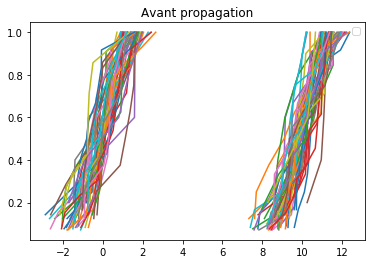

In [17]:
plt.figure()
for k in range(npeers):
    plt.plot(G[k][1],G[k][0])
plt.legend()
plt.title("Avant propagation")

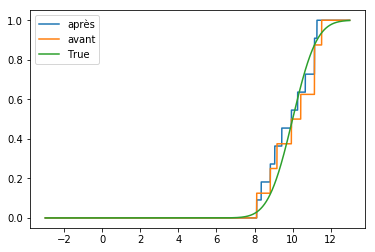

In [18]:
k = np.random.randint(npeers)
plt.plot(invcdfs[k].ts, invcdfs[k].cdf, label='après')

f = F(DATA[k])
plt.plot(invcdfs[k].ts, [f(t) for t in invcdfs[k].ts], label='avant')
plt.plot(invcdfs[k].ts, ss.norm.cdf(invcdfs[k].ts, 10*(y[k]==2)), label='True')
plt.legend()

On affiche la CDF moyenne obtenue après propagation :

New_error = 16.95244410558162


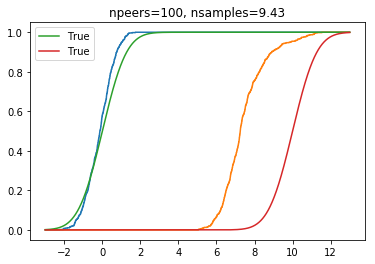

In [19]:
mean1, mean2 = np.zeros(len(invcdfs[0].ts)), np.zeros(len(invcdfs[0].ts))

for k in range(npeers): 
    if y[k]==1:
        mean1 += invcdfs[k].cdf
    else : 
        mean2 += invcdfs[k].cdf
mean1, mean2 = mean1/n1, mean2/n2
plt.figure(1)
plt.plot(invcdfs[0].ts, mean1)
plt.plot(invcdfs[0].ts, mean2)

F_new1 = ss.norm.cdf(invcdfs[0].ts, loc=0)
F_new2 = ss.norm.cdf(invcdfs[0].ts, loc=10)
New_error = (np.linalg.norm(F_new1-mean1)*n1 + np.linalg.norm(F_new2-mean2)*n2)/npeers
print('New_error =', New_error)

#plt.figure(2)
plt.plot(invcdfs[0].ts, F_new1, label='True')
plt.plot(invcdfs[0].ts, F_new2, label='True')
plt.title('npeers=%s, nsamples=%s' %(npeers,np.mean(nsamples)))
plt.legend()

On affiche la CDF moyenne obtenue avant propagation, on constate qu'elle est très bonne...

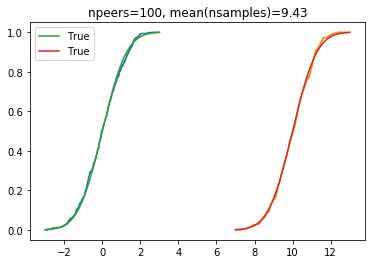

In [20]:
mean1, mean2 = np.zeros(1000), np.zeros(1000)
ts1 = np.linspace(-3,3,1000)
ts2 = np.linspace(7,13,1000)

for k in range(npeers): 
    if y[k]==1:
        #mean1 += np.interp(ts1,G[k][1],G[k][0])
        f = F(DATA[k])
        mean1 += np.array([f(t) for t in ts1])
    else : 
        f = F(DATA[k])
        mean2 += np.array([f(t) for t in ts2])
        #mean2 += np.interp(ts2,G[k][1],G[k][0])
        
mean1, mean2 = mean1/n1, mean2/n2
plt.figure(1)
plt.plot(ts1, mean1)
plt.plot(ts2, mean2)

F_new1 = ss.norm.cdf(ts1, loc=0)
F_new2 = ss.norm.cdf(ts2, loc=10)
New_error = (np.linalg.norm(F_new1-mean1)*n1 + np.linalg.norm(F_new2-mean2)*n2)/npeers

#plt.figure(2)
plt.plot(ts1, F_new1, label='True')
plt.plot(ts2, F_new2, label='True')
plt.title('npeers=%s, mean(nsamples)=%s' %(npeers,np.mean(nsamples)))
plt.legend()

On essaye de mesurer l'erreur en norme L2, on affiche le pourcentage d'augmentation de l'erreur : 

In [21]:
New_error, Previous_error = [], []

for k in range(npeers):
    tt = invcdfs[k].ts
    f = F(DATA[k])
    cdf_before = np.array([f(t) for t in invcdfs[k].ts])
    Cdf_True = ss.norm.cdf(tt, 10*(y[k]==2))
    Previous_error.append(np.linalg.norm(Cdf_True-cdf_before)) # ce qu'on a en entrée
    New_error.append(np.linalg.norm(Cdf_True-invcdfs[k].cdf))

print('previous error :', np.mean(Previous_error), ', new error:', np.mean(New_error))
print('Augmentation de l erreur: %s' %((np.mean(New_error)-np.mean(Previous_error))/np.mean(Previous_error)*100), '%')

previous error : 5.970787165747018 , new error: 19.178257117661843
Augmentation de l erreur: 221.20148625767348 %
